In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import scipy.optimize

In [2]:
data = pd.read_excel("./Q1_Data_modified.xlsx")
a = [d for d in data.iterrows() if d[1][0] == 33522243]
vals = a[0][1].tolist()
id_num = vals[0]
t_r = vals[1]
c_r = vals[2]
t_l = vals[3]
c_l = vals[4]
times = vals[5:]
# who cares about it not working in the future, i only need it to work once

/var/folders/nw/qn2qj07s7qq860r608rn78hm0000gn/T/nix-shell.UrsgxZ/ipykernel_18675/3863792172.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  a = [d for d in data.iterrows() if d[1][0] == 33522243]


In [3]:
class distribution:
    mu_lin = 40
    sigma_lin = 5
    mu_log = 3
    sigma_log = 3
    data = []
    time_right = 0
    count_right = 0
    time_left = 0
    count_left = 0

    def pdf(self, t):
        firstbit_a = (1-scipy.stats.norm.cdf(t, loc=self.mu_lin, scale = self.sigma_lin)) 
        firstbit_b = scipy.stats.lognorm.pdf(t, scale = np.exp(self.mu_log), s=self.sigma_log)
        firstbit = firstbit_a * firstbit_b
        
        secondbit_a = scipy.stats.norm.pdf(t, loc=self.mu_lin, scale = self.sigma_lin) 
        secondbit_b = (1-scipy.stats.lognorm.cdf(t, scale = np.exp(self.mu_log), s=self.sigma_log))
        secondbit = secondbit_a * secondbit_b
        
        return firstbit + secondbit
    
    def cdf(self, t):
        return 1 - ((1-scipy.stats.norm.cdf(t, loc=self.mu_lin, scale = self.sigma_lin)) * (1-scipy.stats.lognorm.cdf(t, scale = np.exp(self.mu_log), s=self.sigma_log)))
    
    def reliability(self, t):
        return 1 - self.cdf(t)
        
    def pre_optimization(self, data, t_r, c_r, t_l, c_l):
        self.data = data
        self.time_right = t_r
        self.count_right = c_r
        self.time_left = t_l
        self.count_left = c_l
    
    def optimization2d(self, values):
        outputs = []
        for i in range(len(values[3])):
            outputs.append([])
            for j in range(len(values[3][0])):
                self.mu_lin = values[0][i][j]
                self.sigma_lin = values[1][i][j]
                self.mu_log = values[2][i][j]
                self.sigma_log = values[3][i][j]
                uncensored = np.sum(np.log(self.pdf(self.data)))
                tmp = self.reliability(self.time_right)
                llike_rc = np.log(tmp if tmp > 0 else 1e-32) * self.count_right
                tmp = self.cdf(self.time_left)
                llike_lc = np.log(tmp if tmp > 0 else 1e-32) * self.count_left
                outputs[i].append((uncensored + llike_rc + llike_lc))
        return outputs

    def optimization(self, values):
        self.mu_lin = values[0]
        self.sigma_lin = values[1]
        self.mu_log = values[2]
        self.sigma_log = values[3]
        datas = self.pdf(self.data)
        llike_un = np.sum(np.log(datas if datas.all() > 0 else 1e-32))
        tmp = self.reliability(self.time_right)
        llike_rc = np.log(tmp if tmp > 0 else 1e-32) * self.count_right
        tmp = self.cdf(self.time_left)
        llike_lc = np.log(tmp if tmp > 0 else 1e-32) * self.count_left
        
        return -1 * (llike_un + llike_rc + llike_lc)

In [4]:
dis = distribution()
dis.pre_optimization(np.array(times), t_r, c_r, t_l, c_l)
optimal_values = scipy.optimize.shgo(dis.optimization, [(20, 60), (0.5, 10), (1, 5), (0.5, 5)])
optimal_values.x, dis.optimization(optimal_values.x)

(array([37.54955321,  1.80514659,  2.80713414,  1.28398706]),
 np.float64(487.3485914423395))

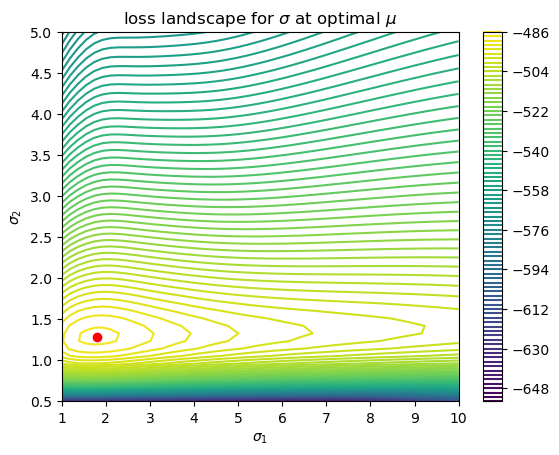

In [5]:
xs = np.linspace(1, 10)
ys = np.linspace(0.5, 5)
a, b= np.meshgrid(xs, ys)
plt.contour(a, b, dis.optimization2d([np.array([[optimal_values.x[0] for _ in a] for _ in a[0]]), a, np.array([[optimal_values.x[2] for _ in a] for _ in a[0]]), b]), levels=100)
plt.colorbar()
plt.scatter(optimal_values.x[1], optimal_values.x[3], c="red")
plt.xlabel("$\\sigma_1$")
plt.ylabel("$\\sigma_2$")
plt.title("loss landscape for $\\sigma$ at optimal $\\mu$")
plt.savefig("report/images/losslandscape_sigma.png")

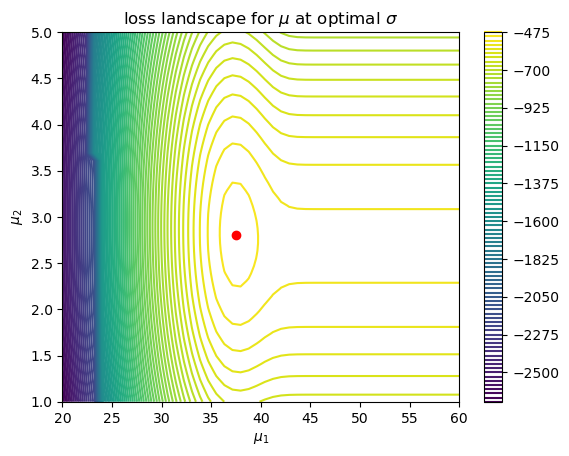

In [6]:
xs = np.linspace(20, 60)
ys = np.linspace(1, 5)
a, b= np.meshgrid(xs, ys)
plt.contour(a, b, dis.optimization2d([a, np.array([[optimal_values.x[1] for _ in a] for _ in a[0]]), b, np.array([[optimal_values.x[3] for _ in xs] for _ in a[0]])]), levels=100)
plt.colorbar()
plt.scatter(optimal_values.x[0], optimal_values.x[2], c="red")
plt.xlabel("$\\mu_1$")
plt.ylabel("$\\mu_2$")
plt.title("loss landscape for $\\mu$ at optimal $\\sigma$")
plt.savefig("report/images/losslandscape_mu.png")

optimal approx $\mu_1 = 30, \sigma_1 = 9, \mu_2 = 2.5, \sigma_2 = 0.6$

error: 1 487.3485914423395


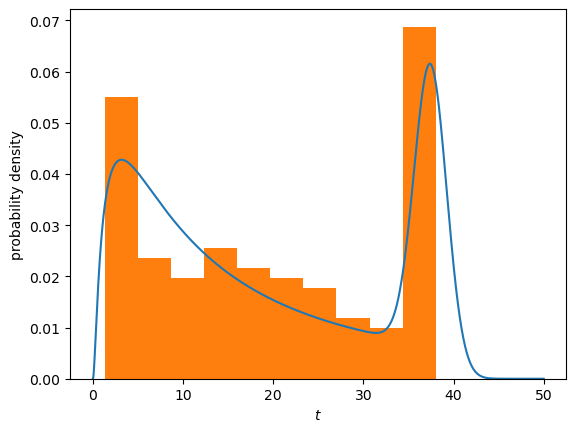

In [7]:
print(f"error: {1}", dis.optimization(optimal_values.x))
xs = np.linspace(0, 50, 1000)
data_with_censored = list(dis.data)
[data_with_censored.append(t_r) for _ in range(int(c_r))]
[data_with_censored.append(t_l) for _ in range(int(c_l))]
plt.plot(xs, dis.pdf(xs))
plt.hist(data_with_censored, density=True)
plt.xlabel("$t$")
plt.ylabel("probability density")
plt.savefig("report/images/1a.png")

In [8]:
optimal_values.x

array([37.54955321,  1.80514659,  2.80713414,  1.28398706])

# 1a answered!!!! yahoooo!!!

In [9]:
dis.cdf(35)

np.float64(0.7420618209960974)

# 1b answered!!! yahooo!!!!

# onto q2

## 2.1 answered in report

In [10]:
def weibull_reliability(time, eta, beta):
    return np.exp(-np.pow(((time)/eta), beta))
    

def m_of_n(m, n, reliabilities):
    total = 0

    for i in range(m):
        total += scipy.special.binom(n, i) * reliabilities[i]**i * (1-reliabilities[i])**(n-i)
    return 1-total 

def parallel(reliabilities):
    return m_of_n(1, len(reliabilities), reliabilities)

In [11]:
def gyro_subsystem(t):
    rel = weibull_reliability(t, 3800, 0.7)
    return m_of_n(1, 3, [rel for _ in range(3)])

def battery_subsystem(t): 
    rel = weibull_reliability(t, 700, 0.7)
    return m_of_n(1, 2, [rel for _ in range(2)])

def computer_subsystem(t):
    return weibull_reliability(t, 900, 0.88)

def control_processor(t):
    return weibull_reliability(t, 400, 1.4)

def electrical_distribution(t):
    return weibull_reliability(t, 1600, 0.5)

def telemetry(t):
    return weibull_reliability(t, 50000, 0.39)

def solar_array(t):
    rel = weibull_reliability(t, 150000, 0.4)
    return m_of_n(3, 4, [rel for _ in range(4)])

def thruster(t): 
    return weibull_reliability(t, 6200, 0.33)

def whole_system(t):
    return gyro_subsystem(t) * battery_subsystem(t) * computer_subsystem(t) * control_processor(t) * electrical_distribution(t) * telemetry(t) * solar_array(t) * thruster(t)


## 2.2 answered!!!

In [12]:
whole_system(20)

np.float64(0.6902260980633155)

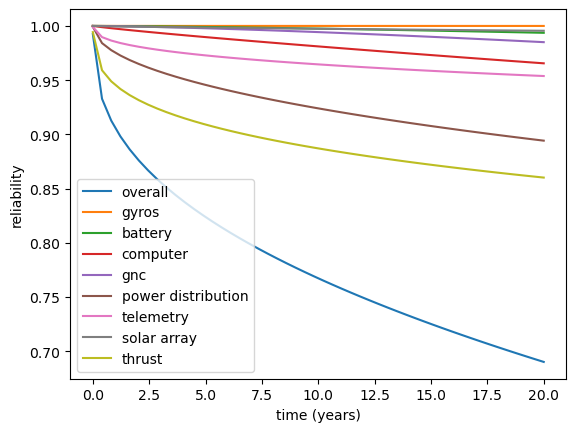

In [13]:
xs = np.linspace(0.001, 20)

plt.plot(xs, whole_system(xs), label="overall")
plt.plot(xs, gyro_subsystem(xs), label="gyros")
plt.plot(xs, battery_subsystem(xs), label="battery")
plt.plot(xs, computer_subsystem(xs), label="computer")
plt.plot(xs, control_processor(xs), label="gnc")
plt.plot(xs, electrical_distribution(xs), label="power distribution")
plt.plot(xs, telemetry(xs), label="telemetry")
plt.plot(xs, solar_array(xs), label="solar array")
plt.plot(xs, thruster(xs), label="thrust")
plt.xlabel("time (years)")
plt.ylabel("reliability")

plt.legend()
plt.savefig("report/images/2b.png")


## 2.3 answered!!! wowweee!!

In [14]:
def routes_available(s):
    output = 0
    output += s[0] and s[3]
    output += s[0] and s[4]
    output += s[1] and s[3]
    output += s[1] and s[4]
    output += s[1] and s[5]
    output += s[2] and s[4]
    output += s[0] and s[5]
    return output

compare_against = whole_system(20)

def monte_carlo():
    numbers = np.random.uniform(size=6)
    status = [n < compare_against for n in numbers]
    if routes_available(status) == 0:
        return 0

    return 1

In [15]:
sum([monte_carlo() for _ in range(500)])/500

0.914

## 2.4 answered!! and thats all done :)):):):::):):

In [16]:
b = np.array([sum([monte_carlo() for _ in range(500)])/500 for _ in range(10000)])

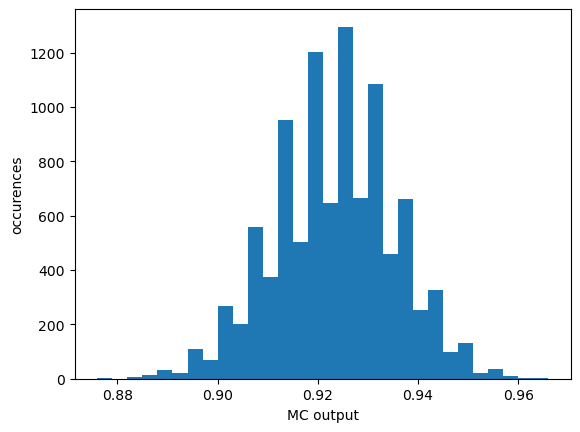

In [26]:
plt.hist(b, bins=30)
plt.xlabel("MC output")
plt.ylabel("occurences")
plt.savefig("report/images/mc-dist.png")